# Spectroscopic overlaps

__Date:__ February 21, 2024

Testing spectroscopic overlaps $\langle \Psi^{A-1}_{\alpha} \lvert a_{\mathbf{q \sigma \tau}} \rvert \Psi^A_0 \rangle$ using SRG transformations.

_Last update:_ July 26, 2024

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
from scipy.integrate import simps
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.special import sph_harm, spherical_jn
from sympy.physics.quantum.cg import CG

In [2]:
# Imports from scripts
from spectroscopic_overlaps_vegas import load
from scripts.figures import set_rc_parameters, label_lambda, label_kvnn
from scripts.integration import gaussian_quadrature_mesh, momentum_mesh
from scripts.momentum_distributions import load_momentum_distribution
from scripts.tools import convert_l_to_string, replace_periods

/Users/anthonytropiano/Documents/GitHub/tropiano-srg/code/spectroscopic_overlaps_vegas.py:291: SyntaxWarning: invalid escape sequence '\p'
  """Create dictionary of \phi(k) interpolated functions where the key
/Users/anthonytropiano/Documents/GitHub/tropiano-srg/code/spectroscopic_overlaps_vegas.py:308: SyntaxWarning: invalid escape sequence '\p'
  """Single-particle wave function \psi_\alpha(k_vector; \sigma, \tau)."""
/Users/anthonytropiano/Documents/GitHub/tropiano-srg/code/spectroscopic_overlaps_vegas.py:460: SyntaxWarning: invalid escape sequence '\d'
  """Computes the plane-wave matrix elements of \delta U or \delta U^\dagger.
/Users/anthonytropiano/Documents/GitHub/tropiano-srg/code/spectroscopic_overlaps_vegas.py:485: SyntaxWarning: invalid escape sequence '\d'
  """Sum over partial waves to evaluate \delta U matrix element in
/Users/anthonytropiano/Documents/GitHub/tropiano-srg/code/spectroscopic_overlaps_vegas.py:572: SyntaxWarning: invalid escape sequence '\d'
  """Interpola

### Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

## Clebsch-Gordan coefficients

In [4]:
def compute_clebsch_gordan_table(j_max):
    """
    Calculate Clebsch-Gordan coefficients for combinations of j and m_j up
    to j_max.
    
    Parameters
    ----------
    j_max : int
        Maximum j value for j_1, j_2, and j_3. This also constrains m_j.
    
    Returns
    -------
    cg_table : dict
        Table of Clebsch-Gordan coefficients <j_1 m_j_1 j_2 m_j_2|j_3 m_j_3>
        for each combination of angular momenta.
        
    """
        
    cg_table = {}
        
    j_array = np.arange(0, j_max+1/2, 1/2)
    
    for j_1 in j_array:
        for j_2 in j_array:
            j_3_array = np.arange(abs(j_1-j_2), j_1+j_2+1)
            for j_3 in j_3_array:
                for m_1 in np.arange(-j_1, j_1+1, 1):
                    for m_2 in np.arange(-j_2, j_2+1, 1):
                        
                        m_3 = m_1 + m_2
                        
                        if abs(m_3) <= j_3:
                            cg_table[(j_1, m_1, j_2, m_2, j_3, m_3)] = float(
                                CG(j_1, m_1, j_2, m_2, j_3, m_3).doit()
                            )
                            
    print(f"Done calculating Clebsch-Gordan table up to j_max = {j_max}.")
                                
    return cg_table

## Single-particle basis

In [5]:
class SingleParticleState:
    """
    Single-particle state class. Packs together the following single-particle
    quantum numbers into one object.
    """
    
    
    def __init__(self, n, l, j, m_j, m_t):
        
        # Check if m_j is valid
        if abs(m_j) > j:
            raise RuntimeError("m_j is not valid.")
            
        # Check that |m_t| = 1/2
        if abs(m_t) != 1/2:
            raise RuntimeError("m_t is not valid.")
            
        self.n = n
        self.l = l
        self.j = j
        self.m_j = m_j
        self.m_t = m_t
        
        if m_t == 1/2:
            self.nucleon = 'proton'
        elif m_t == -1/2:
            self.nucleon = 'neutron'
        
        
    def __eq__(self, sp_state):

        if (
            self.n == sp_state.n and self.l == sp_state.l
            and self.j == sp_state.j and self.m_j == sp_state.m_j
            and self.m_t == sp_state.m_t
        ):
            
            return True
        
        else:
            
            return False
        
        
    def __str__(self):
        
        # Spectroscopic notation of orbital angular momentum
        l_str = convert_l_to_string(self.l)  # E.g., 's', 'p', 'd', ...
        
        # Display j subscript as a fraction
        numerator = 2*int(self.j) + 1
        denominator = 2

        return fr"${self.n}{l_str}_{{{numerator}/{denominator}}}$"

In [6]:
class WoodsSaxon:
    """
    Woods-Saxon orbitals class. Handles the radial wave functions associated
    with the Woods-Saxon potential from the subroutine in woodsaxon.f90. Outputs
    radial functions in coordinate and momentum space.
    
    Parameters
    ----------
    nucleus_name : str
        Name of the nucleus (e.g., 'O16', 'Ca40', etc.)
    Z : int
        Proton number of the nucleus.
    N : int
        Neutron number of the nucleus.
    run_woods_saxon : bool, optional
        Option to run the Woods-Saxon subroutine to generate orbital files.
    n_max : int, optional
        Maximum principal quantum number where n = 1, 2, ..., n_max.
    l_max : int, optional
        Maximum orbital angular momentum where l = 0, 1, ..., l_max.
    rmax : float, optional
        Maximum r for orbital tables.
    ntab : int, optional
        Number of points for orbital tables.
        
    """
    
    def __init__(self, nucleus_name, Z, N, cg_table, rmax=40, ntab=2000,
                 kmax=10.0, kmid=2.0, ntot=120, parametrization='seminole'):
        
        # Set instance attributes
        self.woods_saxon_directory = (
            f"../data/woods_saxon/{parametrization}/{nucleus_name}/"
        )
        self.cg_table = cg_table
        self.A = int(Z + N)

        # Order single-particle states with lowest energy first
        self.order_sp_states(Z, N)
        
        # Organize wave functions in dictionary
        self.sp_wfs = {}
        for sp_state in self.sp_states:
            
            # Wave functions are independent of m_j, so fix m_j=j
            if sp_state.m_j == sp_state.j:
                
                file_name = self.get_orbital_file_name(sp_state)
 
                data = np.loadtxt(self.woods_saxon_directory + file_name)
                
                # Use n, l, j, m_t as the key
                key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t)
                self.sp_wfs[key] = data[:, 1]
                
        # r_array and dr are the same for every s.p. state
        self.r_array = data[:, 0]
        self.dr = max(self.r_array) / len(self.r_array)
        
        # Interpolate occupied s.p. wave functions w.r.t. momentum k
        self.interpolate_wavefunctions(kmax, kmid, ntot)
        
        
    def get_orbital_file_name(self, sp_state):
        """Returns the file name of the orbital."""
            
        # Proton
        if sp_state.m_t == 1/2:
            file_name = (f"p.n{int(sp_state.n-1)}.l{int(sp_state.l)}"
                          f".j{int(2*sp_state.j)}.orb")
        # Neutron
        elif sp_state.m_t == -1/2:
            file_name = (f"n.n{int(sp_state.n-1)}.l{int(sp_state.l)}"
                          f".j{int(2*sp_state.j)}.orb")

        return file_name
        
        
    def order_sp_states(self, Z, N):
        """Keep track of all s.p. states and occupied s.p. states"""

        self.sp_states = []  # All single-particle states
        self.occupied_states = []  # Occupied single-particle states < E_F
        proton_count = 0
        neutron_count = 0
        
        # File with details of the orbitals
        ws_file = self.woods_saxon_directory + "ws_log"
    
        # Order single-particle states using the ws_log file
        with open(ws_file, 'r') as f:
            for line in f:
                unit = line.strip().split()
                
                # Protons
                if len(unit) > 0 and unit[0] == '1':

                    j = int(unit[3])/2
                    for m_j in np.arange(-j, j+1, 1):
                        sp_state = SingleParticleState(
                            int(unit[1])+1, int(unit[2]), j, m_j, 1/2
                        )  # n, l, j, m_j, m_t
                    
                        self.sp_states.append(sp_state)
                    
                        if proton_count < Z:
                            self.occupied_states.append(sp_state)
                            # Add up filled proton states
                            proton_count += 1
                    
                
                # Neutrons
                elif len(unit) > 0 and unit[0] == '2':

                    j = int(unit[3])/2
                    for m_j in np.arange(-j, j+1, 1):
                        sp_state = SingleParticleState(
                            int(unit[1])+1, int(unit[2]), j, m_j, -1/2
                        )  # n, l, j, m_j, m_t
                    
                        self.sp_states.append(sp_state)
                    
                        if neutron_count < N:
                            self.occupied_states.append(sp_state)
                            # Add up filled neutron states
                            neutron_count += 1


    def get_wf_rspace(self, sp_state, print_normalization=False):
        """Single-particle wave function in coordinate space."""
        
        # n, l, j, m_t
        key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t) 
        u_array = self.sp_wfs[key]

        # Normalization: \int dr |u(r)|^2 = 1
        if print_normalization:
            normalization = np.sum(self.dr * u_array ** 2)
            print(f"Coordinate space normalization = {normalization}.")
        
        # Return r and u(r)
        return self.r_array, u_array
    
    
    def fourier_transformation(self, l, r_array, k_array):
        """Fourier transformation matrix for given orbital angular momentum."""
        
        # r_array column vectors and k_array row vectors where both grids are
        # n x m matrices
        r_cols, k_rows = np.meshgrid(r_array, k_array)
        
        # Transformation matrix with shape n x m, where m is the length of
        # r_array and n is the length of the k_array
        M = 1j ** (-l) * np.sqrt(2/np.pi) * self.dr * r_cols * spherical_jn(
            l, k_rows*r_cols
        )
        
        return M
    
    
    def get_wf_kspace(
            self, sp_state, kmax, kmid, ntot, print_normalization=False,
            interpolate=False
    ):
        """Single-particle wave function in momentum space."""
    
        # Set momentum mesh with more points at low momentum
        k_array, k_weights = momentum_mesh(kmax, kmid, ntot)
    
        # Get coordinate-space s.p. wave function
        r_array, u_array = self.get_wf_rspace(sp_state)

        # Fourier-transform the wave function to momentum space
        phi_array = (self.fourier_transformation(sp_state.l, r_array, k_array)
                     @ u_array)
    
        # Normalization: \int dk k^2 |\phi(k)|^2 = 1
        if print_normalization:
            normalization = np.sum(k_weights * k_array ** 2
                                   * abs(phi_array) ** 2)
            print(f"Momentum space normalization = {normalization}.")
            
        # Interpolate and return function?
        if interpolate:
            
            if sp_state.l % 2 == 0:  # Even l
                
                phi_func = InterpolatedUnivariateSpline(k_array, phi_array.real)
                
            else:  # Odd l
            
                phi_func = InterpolatedUnivariateSpline(k_array, phi_array.imag)
                
            return phi_func
        
        # Otherwise return momentum, weights, and \phi(k)
        else:
            return k_array, k_weights, phi_array
        
        
    def interpolate_wavefunctions(self, kmax, kmid, ntot):
        """Create dictionary of \phi(k) interpolated functions where the key
        is the single-particle state.
        """
        
        # Organize interpolated wave functions in dictionary with s.p. quantum
        # numbers as the key
        self.phi_functions = {}
        
        for sp_state in self.occupied_states:
            
            key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t)
            self.phi_functions[key] = self.get_wf_kspace(
                sp_state, kmax, kmid, ntot, interpolate=True
            )
            
    
    def psi(self, sp_state, k, theta, phi, sigma, tau):
        """Single-particle wave function \psi_\alpha(k_vector; \sigma, \tau)."""

        # Calculate \phi_\alpha(k)
        key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t)
        if sp_state.l % 2 == 0:  # Even l
            phi_sp_wf = self.phi_functions[key](k)
        else:  # Odd l needs factor of i^-l
            phi_sp_wf = 1j ** (-sp_state.l) * self.phi_functions[key](k)
    
        # Calculate spinor spherical harmonic
        Y_jml = self.spinor_spherical_harmonic(sp_state.l, sp_state.j,
                                               sp_state.m_j, theta, phi, sigma)
    
        # Isospinor indexed by \tau \chi_{m_t}(\tau)
        chi_tau = kronecker_delta(tau, sp_state.m_t)

        return phi_sp_wf * Y_jml * chi_tau
    

    def spinor_spherical_harmonic(self, l, j, m_j, theta, phi, sigma):
        """Spinor spherical harmonic for a s.p. state described by the quantum
        numbers j, m_j, l, and s=1/2.
        """
        
        # Spinor indexed by \sigma \eta_{m_s}^(\sigma) = \delta_{m_s, \sigma}
        m_s = sigma
    
        # m_l must be fixed since m_j and m_s are determined
        m_l = m_j - m_s
        
        # Check that |m_l| <= l
        if np.abs(m_l) <= l:
        
            # Clebsch-Gordan coefficient for l-s coupling
            cg = self.cg_table[(l, m_l, 1/2, m_s, j, m_j)]
        
            # Spherical harmonic
            Y_lm = sph_harm(m_l, l, phi, theta)
            
            return cg * Y_lm
        
        else:
            
            return np.zeros_like(theta, dtype=complex)

<>:202: SyntaxWarning: invalid escape sequence '\p'
<>:219: SyntaxWarning: invalid escape sequence '\p'
<>:202: SyntaxWarning: invalid escape sequence '\p'
<>:219: SyntaxWarning: invalid escape sequence '\p'
/var/folders/4c/p53tldwd6f76zfs85vnyk3qr0000gn/T/ipykernel_29121/2986728288.py:202: SyntaxWarning: invalid escape sequence '\p'
  """Create dictionary of \phi(k) interpolated functions where the key
/var/folders/4c/p53tldwd6f76zfs85vnyk3qr0000gn/T/ipykernel_29121/2986728288.py:219: SyntaxWarning: invalid escape sequence '\p'
  """Single-particle wave function \psi_\alpha(k_vector; \sigma, \tau)."""


In [7]:
def kronecker_delta(x, y):
    """Kronecker \delta function: \delta_{x,y}."""
    
    return int(x == y)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/var/folders/4c/p53tldwd6f76zfs85vnyk3qr0000gn/T/ipykernel_29121/2574317488.py:2: SyntaxWarning: invalid escape sequence '\d'
  """Kronecker \delta function: \delta_{x,y}."""


In [8]:
def load_vmc_rspace(nucleus_name):
    """Load VMC coordinate-space overlap."""
    
    directory = '../data/vmc/spectroscopic_amplitudes/'
    
    if nucleus_name == 'He4':
        
        data = np.loadtxt(directory + 'h3p.table.txt')
        
        return data
        
    elif nucleus_name == 'C12':
        
        data_12 = np.loadtxt(directory + 'b11p_01p_5.table.txt')
        data_32 = np.loadtxt(directory + 'b11p_03p_5.table.txt')
        data_32x = np.loadtxt(directory + 'b11p_03xp_5.table.txt')
        
        return data_12, data_32, data_32x

In [9]:
def fourier_transform(r_array, rstep, overlap_array, k_array, l):
    """Fourier transform coordinate-space overlap to momentum-space overlap."""
    
    k_grid, r_grid = np.meshgrid(k_array, r_array, indexing='ij')
    _, overlap_grid = np.meshgrid(k_array, overlap_array, indexing='ij')
    
    j_grid = spherical_jn(l, k_grid * r_grid)
    
    factor = 4 * np.pi * rstep
    
    return factor * np.sum(r_grid ** 2 * overlap_grid * j_grid, axis=1)

In [10]:
def load_vmc_kspace(nucleus_name):
    """Load VMC r-space overlaps and Fourier transform to k-space."""
    
    # Momentum mesh [fm^-1]
    k_array, k_weights = momentum_mesh(10.0, 2.0, 120)
    
    if nucleus_name == 'He4':
        
        rdata = load_vmc_rspace(nucleus_name)
        r_array = rdata[:, 0]
        rstep = r_array[2] - r_array[1]
        overlap_r = rdata[:, 1]
        overlap_k = fourier_transform(r_array, rstep, overlap_r, k_array, 0)
        
        return k_array, k_weights, overlap_k
        
    elif nucleus_name == 'C12':
        
        rdata_12, rdata_32, rdata_32x = load_vmc_rspace(nucleus_name)
        r_array = rdata_12[:, 0]
        rstep = r_array[2] - r_array[1]
        overlap_r_12 = rdata_12[:, 1]
        overlap_r_32 = rdata_32[:, 1]
        overlap_r_32x = rdata_32x[:, 1]
        overlap_k_12 = fourier_transform(r_array, rstep, overlap_r_12, k_array,
                                         1)
        overlap_k_32 = fourier_transform(r_array, rstep, overlap_r_32, k_array,
                                         1)
        overlap_k_32x = fourier_transform(r_array, rstep, overlap_r_32x,
                                          k_array, 1)
        
        return k_array, k_weights, overlap_k_12, overlap_k_32, overlap_k_32x

## Coordinate-space overlaps

$N = \int_0^\infty dr r^2 \lvert A(r) \rvert^2$

In [11]:
# data = load_vmc_rspace('He4')
# r_array = data[:, 0]
# vmc_overlap_array = data[:, 1]
# vmc_errors = data[:, 2]

# x_limits = (0, 10)
# y_limits = (-0.1, 1)

# # Print SF
# norm = np.trapz(r_array ** 2 * np.abs(vmc_overlap_array) ** 2, x=r_array)
# print(f"VMC SF = {norm:.5f}")

# plt.close('all')
# f, ax = plt.subplots(figsize=(4, 4))
# ax.errorbar(r_array, vmc_overlap_array, yerr=vmc_errors, label='AV18+UX', ls='',
#             marker='.')
# ax.axhline(y=0, alpha=0.3, color='black')
# ax.set_xlim(x_limits)
# ax.set_ylim(y_limits)
# ax.set_xlabel(r"$r$ [fm]", fontsize=16)
# ax.set_ylabel(r"$A(r)$ [fm" + r'$^{-3/2}$' + ']', fontsize=16)
# ax.legend(loc='upper right', fontsize=12, frameon=False)
# label = r"$^{4}$He($0^+$)" + r"$\rightarrow$" + r"$^3$H($1/2^+$)" + r"$+p$"
# ax.set_title(label, fontsize=16)
# plt.show();

## Momentum-space overlaps

$N = \frac{1}{(2\pi)^3} \int_0^\infty dq q^2 \lvert A(q) \rvert^2$

In [12]:
def load_vmc(nucleus_name, print_normalization=True):
    """
    Loads the VMC spectroscopic overlap.
    
    Notes
    -----
    The spectroscopic overlap has the following normalization:
    
        S_\alpha = 1/(2\pi)^3 \int_0^\infty dq q^2 |A(q)|^2,
        
    where A(q) [fm^3/2] is the overlap.
    
    """
    
    vmc_directory = "../data/vmc/spectroscopic_amplitudes/"
    if nucleus_name == 'He4':
        file_name = "h3p_ms.txt"
        index = 0
    else:
        file_name = "b11p3_ms.txt"
        index = 3
    
    f = open(vmc_directory + file_name, 'r')
    data_list = []
    
    for line in f:
        
        unit = line.strip().split()
        if unit[0] == "#":
            pass
        else:
            data_list.append([
                float(unit[0]), float(unit[1+index]),
                float(unit[2+index].strip('(').strip(')'))
            ])
            
    # Convert to NumPy array
    data = np.array(data_list)
    q_array = data[:, 0]
    overlap_array = data[:, 1]
    errors = data[:, 2]
    
    if print_normalization:
        norm = (
            np.trapz(q_array ** 2 * np.abs(overlap_array) ** 2, x=q_array)
            / (2*np.pi) ** 3
        )
        print(f"VMC SF = {norm:.5f}")
    
    return q_array, overlap_array, errors

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
/var/folders/4c/p53tldwd6f76zfs85vnyk3qr0000gn/T/ipykernel_29121/1035863853.py:2: SyntaxWarning: invalid escape sequence '\p'
  """


In [13]:
def check_sf(q_array, q_weights, overlap_array):
    """Check SF using VMC convention."""
    
    return 1 / (2*np.pi) ** 3 * np.sum(q_weights * q_array ** 2
                                       * np.abs(overlap_array) ** 2)

In [14]:
# Settings for operator evolution
kvnn = 6
lamb = 1.5
channels = ('1S0', '3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1')

### $^4$He overlap

$^{4}$He($0^+$) $\rightarrow$ $^3$H($1/2^+$) $+p$</br>
VMC uses AV18 and UX</br>
SRG uses AV18 at $\lambda=1.5$ fm$^{-1}$

In [15]:
nucleus_name, Z, N = 'He4', 2, 2
n, l, j, m_t = 1, 0, 1/2, 1/2  # 1s_{1/2}
filename = (replace_periods(f"{nucleus_name}_proton_n{n}_l{l}_j{2*j}"
                            f"_overlap_kvnn_{kvnn}_lamb_{lamb}") + '.txt')
q_array, q_weights, overlap_array, errors, ipm_array = load(filename)

# VMC with AV18+UX
q_vmc, qw_vmc, vmc_overlap = load_vmc_kspace(nucleus_name)

# Check SF
sf_srg = check_sf(q_array, q_weights, overlap_array)
print(f"SRG SF = {sf_srg:.5f}")
sf_ipm = check_sf(q_array, q_weights, ipm_array)
print(f"Unevolved SF = {sf_ipm:.5f}")
sf_vmc = check_sf(q_vmc, qw_vmc, vmc_overlap)
print(f"VMC SF = {sf_vmc:.5f}")

SRG SF = 1.56986
Unevolved SF = 1.70701
VMC SF = 1.62011


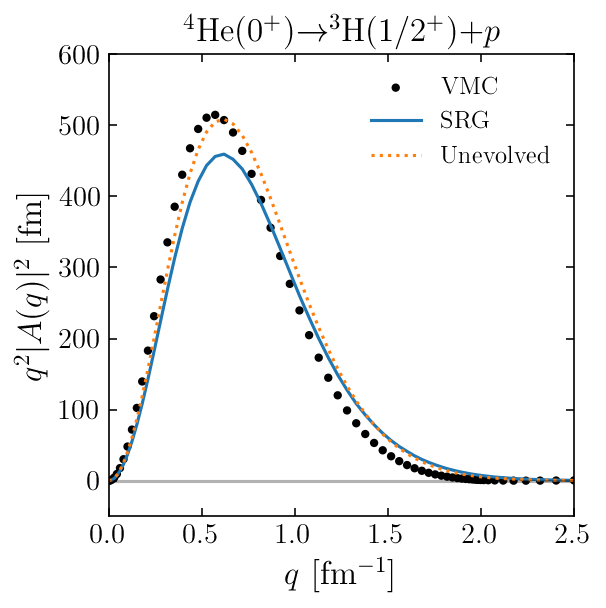

In [16]:
x_limits = (0, 2.5)
y_limits = (-50, 600)

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('linear')
ax.scatter(q_vmc, vmc_overlap ** 2 * q_vmc ** 2, label='VMC', ls='', marker='.',
           color='black')
ax.plot(q_array, q_array ** 2 * np.abs(overlap_array) ** 2, label='SRG')
ax.plot(q_array, q_array ** 2 * np.abs(ipm_array) ** 2, label='Unevolved',
        ls='dotted')
ax.axhline(y=0, alpha=0.3, color='black')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$q^2 |A(q)|^2$ [fm]", fontsize=16)
ax.legend(loc='upper right', fontsize=12, frameon=False)
ax.set_title(r"$^{4}$He($0^+$)" + r"$\rightarrow$" + r"$^3$H($1/2^+$)"
             + r"$+p$", fontsize=16)
plt.show();

In [17]:
# # x_limits = (0, 10)
# # y_limits = (1e-5, 1e2)
# x_limits = (0, 5)
# y_limits = (1e-3, 1e2)

# plt.close('all')
# f, ax = plt.subplots(figsize=(4, 4))
# ax.set_yscale('log')
# ax.scatter(q_vmc, np.abs(vmc_overlap), label='VMC', ls='', marker='.',
#            color='black')
# ax.plot(q_array, np.abs(overlap_array), label='SRG')
# ax.plot(q_array, np.abs(ipm_array), label='Unevolved', ls='dotted')
# ax.set_xlim(x_limits)
# ax.set_ylim(y_limits)
# ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
# ax.set_ylabel(r"$|A(q)|$ [fm" + r'$^{3/2}$' + ']', fontsize=16)
# ax.legend(loc='upper right', fontsize=12, frameon=False)
# ax.set_title(r"$^{4}$He($0^+$)" + r"$\rightarrow$" + r"$^3$H($1/2^+$)"
#              + r"$+p$", fontsize=16)
# plt.show();

### $^{12}$C overlap

$^{12}$C($0^+$) $\rightarrow$ $^{11}$B($3/2^-$) $+p$</br>
VMC uses AV18 and UX</br>
SRG uses AV18 at $\lambda=1.5$ fm$^{-1}$

In [18]:
nucleus_name, Z, N = 'C12', 6, 6
n, l, j, m_t = 1, 1, 3/2, 1/2  # 1p_{3/2}
filename = (replace_periods(f"{nucleus_name}_proton_n{n}_l{l}_j{2*j}"
                            f"_overlap_kvnn_{kvnn}_lamb_{lamb}") + '.txt')
q_array, q_weights, overlap_array, errors, ipm_array = load(filename)

# VMC with AV18+UX
q_vmc, qw_vmc, vmc_overlap_12, vmc_overlap_32, vmc_overlap_32x = (
    load_vmc_kspace(nucleus_name)
)
vmc_overlap = np.sqrt(vmc_overlap_12 ** 2 + vmc_overlap_32 ** 2
                      + vmc_overlap_32x ** 2)

# Check SF
sf_srg = check_sf(q_array, q_weights, overlap_array)
print(f"SRG SF = {sf_srg:.5f}")
sf_ipm = check_sf(q_array, q_weights, ipm_array)
print(f"Unevolved SF = {sf_ipm:.5f}")
sf_vmc_32 = check_sf(q_vmc, qw_vmc, vmc_overlap_32)
print(f"VMC SF = {sf_vmc_32:.5f}")
sf_vmc = check_sf(q_vmc, qw_vmc, vmc_overlap)
print(f"VMC sum of SF's = {sf_vmc:.5f}")

SRG SF = 3.54299
Unevolved SF = 3.86368
VMC SF = 2.36204
VMC sum of SF's = 3.38664


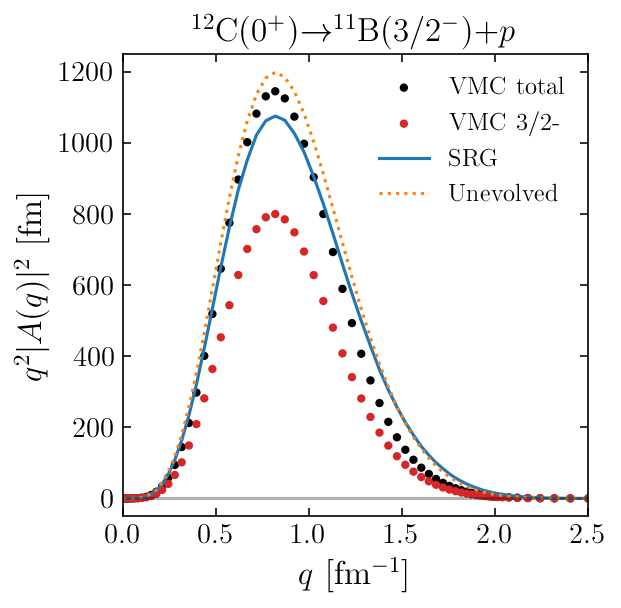

In [19]:
x_limits = (0, 2.5)
y_limits = (-50, 1250)

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('linear')
ax.scatter(q_vmc, vmc_overlap ** 2 * q_vmc ** 2, label='VMC total', ls='',
           marker='.', color='black')
ax.scatter(q_vmc, vmc_overlap_32 ** 2 * q_vmc ** 2, label='VMC 3/2-', ls='',
           marker='.', color='tab:red')
ax.plot(q_array, q_array ** 2 * np.abs(overlap_array) ** 2, label='SRG')
ax.plot(q_array, q_array ** 2 * np.abs(ipm_array) ** 2, label='Unevolved',
        ls='dotted')
ax.axhline(y=0, alpha=0.3, color='black')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$q^2 |A(q)|^2$ [fm]", fontsize=16)
ax.legend(loc='upper right', fontsize=12, frameon=False)
ax.set_title(r"$^{12}$C($0^+$)" + r"$\rightarrow$" + r"$^{11}$B($3/2^-$)"
             + r"$+p$", fontsize=16)
plt.show();

In [20]:
# # x_limits = (0, 10)
# # y_limits = (1e-4, 1e2)
# x_limits = (0, 5)
# y_limits = (1e-3, 1e2)

# plt.close('all')
# f, ax = plt.subplots(figsize=(4, 4))
# ax.set_yscale('log')
# ax.scatter(q_vmc, np.abs(vmc_overlap), label='VMC total', ls='', marker='.',
#            color='black')
# ax.scatter(q_vmc, np.abs(vmc_overlap_32), label='VMC 3/2-', ls='', marker='.',
#            color='tab:red')
# ax.plot(q_array, np.abs(overlap_array), label='SRG')
# ax.plot(q_array, np.abs(ipm_array), label='Unevolved', ls='dotted')
# ax.set_xlim(x_limits)
# ax.set_ylim(y_limits)
# ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
# ax.set_ylabel(r"$|A(q)|$ [fm" + r'$^{3/2}$' + ']', fontsize=16)
# ax.legend(loc='upper right', fontsize=12, frameon=False)
# ax.set_title(r"$^{12}$C($0^+$)" + r"$\rightarrow$" + r"$^{11}$B($3/2^-$)"
#              + r"$+p$", fontsize=16)
# plt.show();

In [21]:
def load_vmc_with_errors(nucleus_name, print_normalization=True):
    """
    Loads the VMC spectroscopic overlap.
    
    Notes
    -----
    The spectroscopic overlap has the following normalization:
    
        S_\alpha = 1/(2\pi)^3 \int_0^\infty dq q^2 |A(q)|^2,
        
    where A(q) [fm^3/2] is the overlap.
    
    """
    
    vmc_directory = "../data/vmc/spectroscopic_amplitudes/"
    if nucleus_name == 'He4':
        file_name = "h3p_ms.txt"
        index = 0
    else:
        file_name = "b11p3_ms.txt"
        index = 3
    
    f = open(vmc_directory + file_name, 'r')
    data_list = []
    
    for line in f:
        
        unit = line.strip().split()
        if unit[0] == "#":
            pass
        else:
            data_list.append([
                float(unit[0]), float(unit[1+index]),
                float(unit[2+index].strip('(').strip(')'))
            ])
            
    # Convert to NumPy array
    data = np.array(data_list)
    q_array = data[:, 0]
    overlap_array = data[:, 1]
    errors = data[:, 2]
    
    if print_normalization:
        norm = (
            np.trapz(q_array ** 2 * np.abs(overlap_array) ** 2, x=q_array)
            / (2*np.pi) ** 3
        )
        print(f"VMC SF = {norm:.5f}")
    
    return q_array, overlap_array, errors

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
/var/folders/4c/p53tldwd6f76zfs85vnyk3qr0000gn/T/ipykernel_29121/323043333.py:2: SyntaxWarning: invalid escape sequence '\p'
  """


In [22]:
# # VMC overlap with errors
# q_vmc, vmc_overlap, vmc_errors = load_vmc_with_errors('C12')

# # x_limits = (0, 10)
# # y_limits = (1e-4, 1e2)
# x_limits = (0, 5)
# y_limits = (1e-3, 1e2)

# plt.close('all')
# f, ax = plt.subplots(figsize=(4, 4))
# ax.set_yscale('log')
# ax.errorbar(q_vmc, np.abs(vmc_overlap), yerr=vmc_errors, label='VMC', ls='',
#             marker='.', color='black')
# ax.plot(q_array, np.abs(overlap_array), label='SRG')
# ax.plot(q_array, np.abs(ipm_array), label='Unevolved', ls='dotted')
# ax.set_xlim(x_limits)
# ax.set_ylim(y_limits)
# ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
# ax.set_ylabel(r"$|A(q)|$ [fm" + r'$^{3/2}$' + ']', fontsize=16)
# ax.legend(loc='upper right', fontsize=9, frameon=False)
# label = r"$^{12}$C($0^+$)" + r"$\rightarrow$" + r"$^{11}$B($3/2^-$)" + r"$+p$"
# ax.set_title(label, fontsize=16)
# plt.show();

### $^{56}$Ni overlap

In [23]:
nucleus_name, Z, N = 'Ni56', 28, 28
n, l, j, m_t = 1, 3, 7/2, 1/2  # 1f_{7/2}
filename = (replace_periods(f"{nucleus_name}_proton_n{n}_l{l}_j{2*j}"
                            f"_overlap_kvnn_{kvnn}_lamb_{lamb}") + '.txt')
q_array, q_weights, overlap_array, errors, ipm_array = load(filename)

# Check SF
sf_srg = check_sf(q_array, q_weights, overlap_array)
print(f"SRG SF = {sf_srg:.5f}")
sf_ipm = check_sf(q_array, q_weights, ipm_array)
print(f"Unevolved SF = {sf_ipm:.5f}")

# Normalization from Barbieri (2009)
sf_barbieri = 0.71 * (2*j+1)
print(f"Barbieri SF = {sf_barbieri:.5f}")

SRG SF = 7.17435
Unevolved SF = 7.94384
Barbieri SF = 5.68000


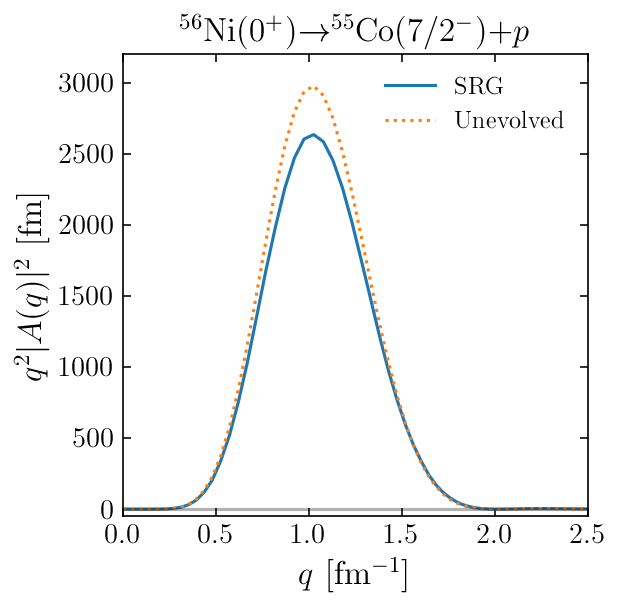

In [24]:
x_limits = (0, 2.5)
y_limits = (-50, 3200)

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('linear')
ax.plot(q_array, q_array ** 2 * np.abs(overlap_array) ** 2, label='SRG')
ax.plot(q_array, q_array ** 2 * np.abs(ipm_array) ** 2, label='Unevolved',
        ls='dotted')
ax.axhline(y=0, alpha=0.3, color='black')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$q^2 |A(q)|^2$ [fm]", fontsize=16)
ax.legend(loc='upper right', fontsize=12, frameon=False)
ax.set_title(r"$^{56}$Ni($0^+$)" + r"$\rightarrow$" + r"$^{55}$Co($7/2^-$)"
             + r"$+p$", fontsize=16)
plt.show();

In [25]:
# # x_limits = (0, 10)
# # y_limits = (1e-4, 1e2)
# x_limits = (0, 5)
# y_limits = (1e-3, 1e2)

# plt.close('all')
# f, ax = plt.subplots(figsize=(4, 4))
# ax.set_yscale('log')
# ax.plot(q_array, np.abs(overlap_array), label='SRG')
# ax.plot(q_array, np.abs(ipm_array), label='Unevolved', ls='dotted')
# ax.set_xlim(x_limits)
# ax.set_ylim(y_limits)
# ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
# ax.set_ylabel(r"$|A(q)|$ [fm" + r'$^{3/2}$' + ']', fontsize=16)
# ax.legend(loc='upper right', fontsize=12, frameon=False)
# ax.set_title(r"$^{56}$Ni($0^+$)" + r"$\rightarrow$" + r"$^{55}$Co($7/2^-$)"
#              + r"$+p$", fontsize=16)
# plt.show();

### $^{16}$O overlap

In [26]:
nucleus_name, Z, N = 'O16', 8, 8
n, l, j, m_t = 1, 1, 1/2, 1/2  # 1p_{1/2}
filename = (replace_periods(f"{nucleus_name}_proton_n{n}_l{l}_j{2*j}"
                            f"_overlap_kvnn_{kvnn}_lamb_{lamb}") + '.txt')
q_array, q_weights, overlap_array, errors, ipm_array = load(filename)

# Check SF
sf_srg = check_sf(q_array, q_weights, overlap_array)
print(f"SRG SF = {sf_srg:.5f}")
sf_ipm = check_sf(q_array, q_weights, ipm_array)
print(f"Unevolved SF = {sf_ipm:.5f}")

SRG SF = 1.75352
Unevolved SF = 1.94283


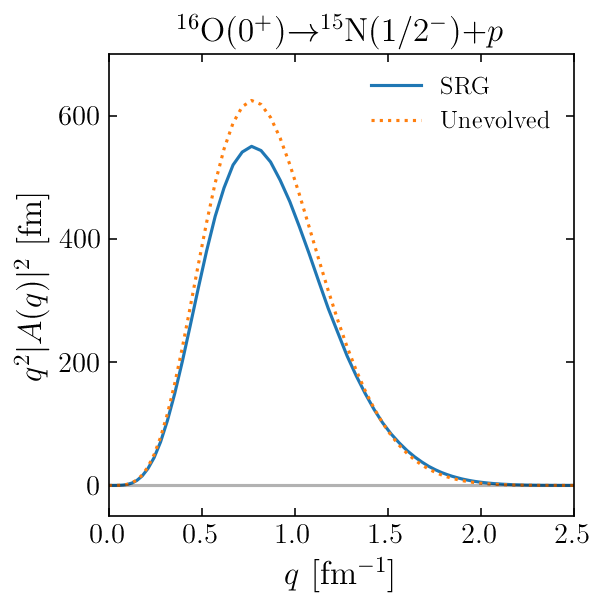

In [27]:
x_limits = (0, 2.5)
y_limits = (-50, 700)

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('linear')
ax.plot(q_array, q_array ** 2 * np.abs(overlap_array) ** 2, label='SRG')
ax.plot(q_array, q_array ** 2 * np.abs(ipm_array) ** 2, label='Unevolved',
        ls='dotted')
ax.axhline(y=0, alpha=0.3, color='black')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$q^2 |A(q)|^2$ [fm]", fontsize=16)
ax.legend(loc='upper right', fontsize=12, frameon=False)
ax.set_title(r"$^{16}$O($0^+$)" + r"$\rightarrow$" + r"$^{15}$N($1/2^-$)"
             + r"$+p$", fontsize=16)
plt.show();

### $^{40}$Ar overlap

In [28]:
# nucleus_name, Z, N = 'Ar40', 18, 22
# n, l, j, m_t = 2, 0, 1/2, 1/2  # 2s_{1/2}
# filename = (replace_periods(f"{nucleus_name}_proton_n{n}_l{l}_j{2*j}"
#                             f"_overlap_kvnn_{kvnn}_lamb_{lamb}") + '.txt')
# q_array, q_weights, overlap_array, errors, ipm_array = load(filename)

# # Check SF
# sf_srg = check_sf(q_array, q_weights, overlap_array)
# print(f"SRG SF = {sf_srg:.5f}")
# sf_ipm = check_sf(q_array, q_weights, ipm_array)
# print(f"Unevolved SF = {sf_ipm:.5f}")

In [29]:
# x_limits = (0, 2.5)
# y_limits = (-50, 700)

# plt.close('all')
# f, ax = plt.subplots(figsize=(4, 4))
# ax.set_yscale('linear')
# ax.plot(q_array, q_array ** 2 * np.abs(overlap_array) ** 2, label='SRG')
# ax.plot(q_array, q_array ** 2 * np.abs(ipm_array) ** 2, label='Unevolved',
#         ls='dotted')
# ax.axhline(y=0, alpha=0.3, color='black')
# ax.set_xlim(x_limits)
# ax.set_ylim(y_limits)
# ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
# ax.set_ylabel(r"$q^2 |A(q)|^2$ [fm]", fontsize=16)
# ax.legend(loc='upper right', fontsize=12, frameon=False)
# ax.set_title(r"$^{40}$Ar($0^+$)" + r"$\rightarrow$" + r"$^{39}$Cl($1/2^+$)"
#              + r"$+p$", fontsize=16)
# plt.show();

In [30]:
# # x_limits = (0, 10)
# # y_limits = (1e-4, 1e2)
# x_limits = (0, 5)
# y_limits = (1e-3, 1e3)

# plt.close('all')
# f, ax = plt.subplots(figsize=(4, 4))
# ax.set_yscale('log')
# ax.plot(q_array, np.abs(overlap_array), label='SRG')
# ax.plot(q_array, np.abs(ipm_array), label='Unevolved', ls='dotted')
# ax.set_xlim(x_limits)
# ax.set_ylim(y_limits)
# ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
# ax.set_ylabel(r"$|A(q)|$ [fm" + r'$^{3/2}$' + ']', fontsize=16)
# ax.legend(loc='upper right', fontsize=12, frameon=False)
# ax.set_title(r"$^{40}$Ar($0^+$)" + r"$\rightarrow$" + r"$^{39}$Cl($1/2^+$)"
#              + r"$+p$", fontsize=16)
# plt.show();

### Compare chiral and AV18

In [31]:
lamb = 1.5
channels = ('1S0', '3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1')
# kvnn numbers
kvnns = [6, 7, 79, 113]

AV18 SF = 7.17435
CD-Bonn SF = 7.42579
EMN N4LO SF = 7.51846
SMS N4LO SF = 7.39191
Unevolved SF = 7.94384


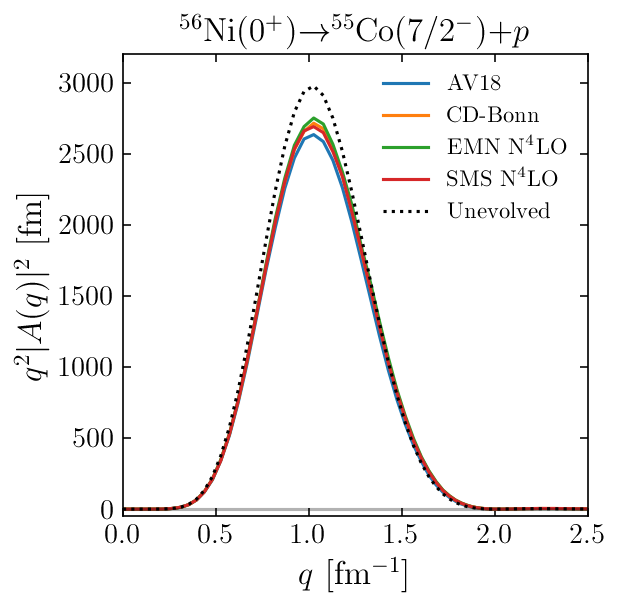

In [32]:
# 56Ni
nucleus_name, Z, N = 'Ni56', 28, 28
n, l, j, m_t = 1, 3, 7/2, 1/2  # 1f_{7/2}

# Plot
label = r"$^{56}$Ni($0^+$)" + r"$\rightarrow$" + r"$^{55}$Co($7/2^-$)" + r"$+p$"
x_limits = (0, 2.5)
y_limits = (-50, 3200)
plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('linear')

for kvnn in kvnns:
    
    filename = (replace_periods(f"{nucleus_name}_proton_n{n}_l{l}_j{2*j}"
                                f"_overlap_kvnn_{kvnn}_lamb_{lamb}") + '.txt')
    q_array, q_weights, overlap_array, errors, ipm_array = load(filename)
    # Check SF
    sf = check_sf(q_array, q_weights, overlap_array)
    if kvnn == 6:
        kvnn_label = 'AV18'
    elif kvnn == 7:
        kvnn_label = 'CD-Bonn'
    elif kvnn == 79:
        kvnn_label = 'EMN N4LO'
    elif kvnn == 113:
        kvnn_label = 'SMS N4LO'
    print(f"{kvnn_label} SF = {sf:.5f}")
    ax.plot(q_array, q_array ** 2 * np.abs(overlap_array) ** 2,
            label=label_kvnn(kvnn, full_label=False))
    
# Plot IPM once and print SF
sf_ipm = check_sf(q_array, q_weights, ipm_array)
print(f"Unevolved SF = {sf_ipm:.5f}")
ax.plot(q_array, q_array ** 2 * np.abs(ipm_array) ** 2, color='black',
        ls='dotted', label="Unevolved")
ax.axhline(y=0, alpha=0.3, color='black')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$q^2 |A(q)|^2$ [fm]", fontsize=16)
ax.legend(loc='upper right', fontsize=11, frameon=False)
ax.set_title(label, fontsize=16)
plt.show();

### $\lambda$ dependence

In [33]:
# channels = ('1S0', '3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1')
# kvnn = 6

In [34]:
# # 4He
# nucleus_name, Z, N = 'He4', 2, 2
# n, l, j, m_t = 1, 0, 1/2, 1/2  # 1s_{1/2}

# # \lambda = 3.0
# filename_3 = (replace_periods(f"{nucleus_name}_proton_n{n}_l{l}_j{2*j}"
#                               f"_overlap_kvnn_{kvnn}_lamb_{3.0}") + '.txt')
# q_3, qw_3, overlap_3, errors_3, ipm_3 = load(filename_3)

# # Check SF
# sf_ipm = check_sf(q_3, qw_3, ipm_3)
# print(f"\lambda = \infty: SF = {sf_ipm:.5f}")
# sf_srg_3 = check_sf(q_3, qw_3, overlap_3)
# print(f"\lambda = 3.0: SF = {sf_srg_3:.5f}")

# # \lambda = 1.5
# filename_15 = (replace_periods(f"{nucleus_name}_proton_n{n}_l{l}_j{2*j}"
#                                f"_overlap_kvnn_{kvnn}_lamb_{1.5}") + '.txt')
# q_15, qw_15, overlap_15, errors_15, ipm_15 = load(filename_15)
# # Check SF
# sf_srg_15 = check_sf(q_15, qw_15, overlap_15)
# print(f"\lambda = 1.5: SF = {sf_srg_15:.5f}")

# # VMC with AV18+UX
# q_vmc, qw_vmc, vmc_overlap = load_vmc_kspace(nucleus_name)

# # Plot
# label = r"$^{4}$He($0^+$)" + r"$\rightarrow$" + r"$^3$H($1/2^+$)" + r"$+p$"
# x_limits = (0, 2.5)
# y_limits = (-50, 600)
# plt.close('all')
# f, ax = plt.subplots(figsize=(4, 4))
# ax.set_yscale('linear')
# ax.scatter(q_vmc, vmc_overlap ** 2 * q_vmc ** 2, label='VMC', ls='', marker='.',
#            color='black')
# ax.plot(q_3, q_3 ** 2 * np.abs(overlap_3) ** 2, label=label_lambda(3.0))
# ax.plot(q_15, q_15 ** 2 * np.abs(overlap_15) ** 2, label=label_lambda(1.5))
# ax.axhline(y=0, alpha=0.3, color='black')
# ax.set_xlim(x_limits)
# ax.set_ylim(y_limits)
# ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
# ax.set_ylabel(r"$q^2 |A(q)|^2$ [fm]", fontsize=16)
# ax.legend(loc='upper right', fontsize=12, frameon=False)
# ax.set_title(label, fontsize=16)
# plt.show();

### Compare $^{16}$O momentum distribution to sum of overlaps squared

$$
n(\mathbf{q}) = \sum_\alpha \lvert \langle \Psi_\alpha^{A-1} \lvert a_{\mathbf{q}} \rvert \Phi_0^A \rangle \rvert^2 \\
= \sum_\alpha \lvert A_\alpha(\mathbf{q}) \rvert^2
$$

Possible sources of discrepancy:
</br>

1. Differences in truncation of many-body operators in
</br>
$\langle \Phi^A \lvert U a^\dagger_q a_q U^\dagger \rvert \Phi^A \rangle$ vs $\langle \Phi^A \lvert U a_q^\dagger U^\dagger \rvert \Psi^{A-1} \rangle \langle \Psi^{A-1} \lvert U a_q U^\dagger \rvert \Phi^A \rangle$
</br></br>
    
2. Assumption that
</br>
$\langle \Psi^{A-1}_\alpha(\lambda) \vert \rightarrow \langle \Psi^A_0(\lambda) \vert a^\dagger_\alpha$
</br></br>
    
3. Truncation of sum over all states to only occupied states
</br>
$\sum_\alpha \lvert A_\alpha(\mathbf{q}) \rvert^2 \rightarrow \sum_{\alpha<F} \lvert A_\alpha(\mathbf{q}) \rvert^2$

In [35]:
kvnn = 6
lamb = 1.5

In [36]:
# Momentum distribution
q_md, qw_md, n_array, _, I_array, _, _, _, _ = load_momentum_distribution(
    'O16', 'proton', kvnn, lamb, parametrization='seminole'
)

# Multiply by (2 \pi)^3 * (4 \pi) so that the normalization is
# 1 / (2 \pi)^3 \int dq q^2 n(q) = Z
factor = (2*np.pi) ** 3 * (4*np.pi)
n_array *= factor
I_array *= factor

norm =  1 / (2*np.pi) ** 3 * np.sum(qw_md * q_md ** 2 * n_array)
print(f"Normalization of momentum distribution = {norm:.5f}")

Normalization of momentum distribution = 8.00012


In [37]:
# Sum of spectroscopic overlaps squared
nucleus_name, Z, N = 'O16', 8, 8
states = [(1, 0, 1/2, 1/2), (1, 1, 3/2, 1/2), (1, 1, 1/2, 1/2)]
overlap_squared = np.zeros(120)
ipm_squared = np.zeros(120)
sf_sum = 0

for state in states:
    
    n, l, j, m_t = state
    filename = (replace_periods(f"{nucleus_name}_proton_n{n}_l{l}_j{2*j}"
                                f"_overlap_kvnn_{kvnn}_lamb_{lamb}") + '.txt')
    q_array, q_weights, overlap_array, errors, ipm_array = load(filename)
    
    

    # Check SF
    sf_srg = check_sf(q_array, q_weights, overlap_array)
    sf_sum += sf_srg
    print(f"l={l:d}, j={j:.1f}, SF = {sf_srg:.5f}")

    overlap_squared += np.abs(overlap_array) ** 2
    ipm_squared += np.abs(ipm_array) ** 2
    
print(f"Sum of SF's = {sf_sum:.5f}")

l=0, j=0.5, SF = 1.65293
l=1, j=1.5, SF = 3.49569
l=1, j=0.5, SF = 1.75352
Sum of SF's = 6.90214


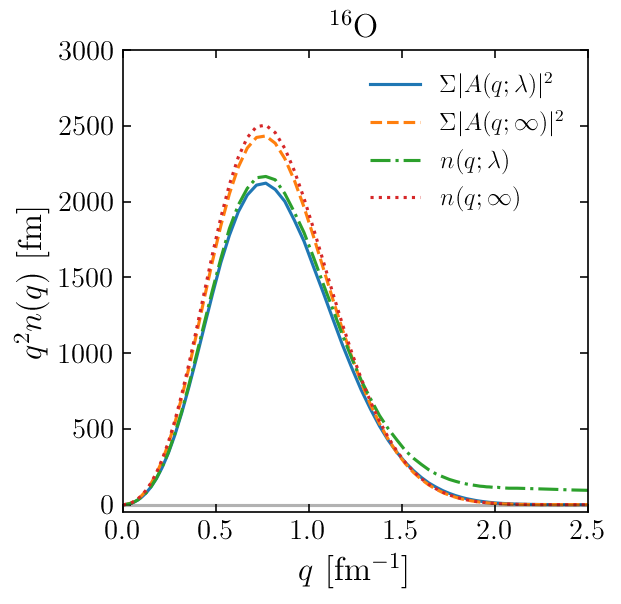

In [38]:
x_limits = (0, 2.5)
y_limits = (-50, 3000)

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('linear')
ax.plot(q_array, q_array ** 2 * overlap_squared,
        label=r"$\Sigma |A(q;\lambda)|^2$")
ax.plot(q_array, q_array ** 2 * ipm_squared, label=r"$\Sigma |A(q;\infty)|^2$",
        ls='dashed')
ax.plot(q_md, q_md ** 2 * n_array, label=r'$n(q;\lambda)$', ls='dashdot')
ax.plot(q_md, q_md ** 2 * I_array, label=r'$n(q;\infty)$', ls='dotted')
ax.axhline(y=0, alpha=0.3, color='black')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$q^2 n(q)$ [fm]", fontsize=16)
ax.legend(loc='upper right', fontsize=12, frameon=False)
ax.set_title(r"$^{16}$O", fontsize=16)
plt.show();

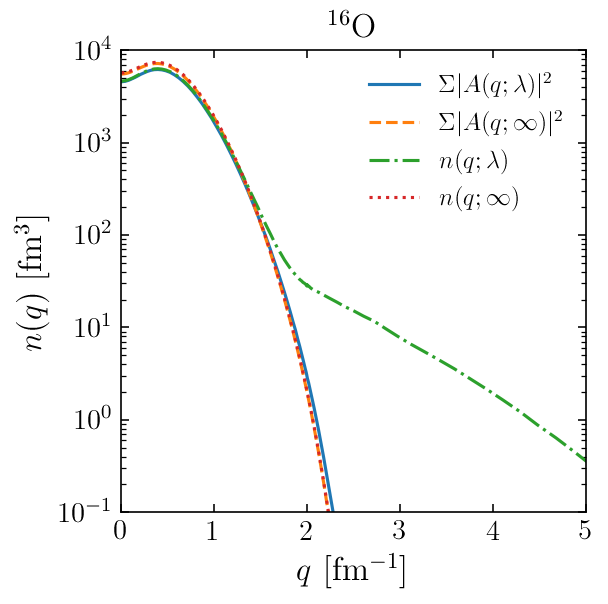

In [39]:
x_limits = (0, 5)
y_limits = (1e-1, 1e4)

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('log')
ax.plot(q_array, overlap_squared, label=r"$\Sigma |A(q;\lambda)|^2$")
ax.plot(q_array, ipm_squared, label=r"$\Sigma |A(q;\infty)|^2$", ls='dashed')
ax.plot(q_md, n_array, label=r'$n(q;\lambda)$', ls='dashdot')
ax.plot(q_md, I_array, label=r'$n(q;\infty)$', ls='dotted')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$n(q)$ [fm$^3$]", fontsize=16)
ax.legend(loc='upper right', fontsize=12, frameon=False)
ax.set_title(r"$^{16}$O", fontsize=16)
plt.show();